In [2]:
from cpsrl.models.mean import LinearMean
from cpsrl.models.covariance import EQ
from cpsrl.models.gp import VFEGP

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

dtype = tf.float64

In [47]:
def f(x):
    return tf.sin(2 * np.pi * x) + 0.5 * x

xmin = -1.
xmax = 1.
num_points = 20
data_noise = 1e-1

x_train = tf.random.uniform(minval=xmin, maxval=xmax, shape=(num_points, 1))
x_train = tf.cast(x_train, dtype=dtype)

y_train = f(x_train)
y_train = y_train + tf.random.normal(mean=0.,
                                     stddev=data_noise,
                                     shape=(num_points, 1),
                                     dtype=dtype)

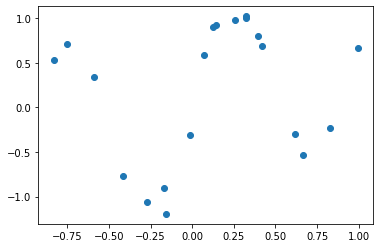

In [48]:
plt.scatter(x_train.numpy(), y_train.numpy())
plt.show()

In [49]:
trainable_mean = True

linear_mean = LinearMean(input_dim=1,
                         trainable=trainable_mean,
                         dtype=dtype)

In [82]:
# Set random seed to run the same test always
tf.random.set_seed(0)

# Set all parameters to trainable
trainable_mean = False
trainable_cov = False
trainable_noise = True
trainable_inducing = False

log_coeff = 0.
log_scales = [-1.]
log_noise = -2.
num_ind = num_points

# Initialise mean and covariance
mean = LinearMean(input_dim=1,
                  trainable=trainable_mean,
                  dtype=dtype)

cov = EQ(log_coeff=log_coeff,
         log_scales=log_scales,
         trainable=trainable_cov,
         dtype=dtype)

# Initialise Variational Free Energy GP
vfe_gp = VFEGP(mean=mean,
               cov=cov,
               input_dim=1,
               x_train=x_train,
               y_train=y_train,
               x_ind=None,
               num_ind=num_ind,
               trainable_inducing=trainable_inducing,
               log_noise=log_noise,
               trainable_noise=trainable_noise,
               dtype=dtype)

# Check optimisation works without error
num_steps = 1000
optimizer = tf.keras.optimizers.Adam(1e-1)

for step in range(num_steps + 1):
    with tf.GradientTape() as tape:
        tape.watch(vfe_gp.trainable_variables)

        free_energy = vfe_gp.free_energy()
        loss = - free_energy
        if step % 100 == 0: print(loss)

    gradients = tape.gradient(loss, vfe_gp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vfe_gp.trainable_variables))

tf.Tensor(222.8542995003134, shape=(), dtype=float64)
tf.Tensor(3.3653375567767667, shape=(), dtype=float64)
tf.Tensor(2.7367769006204696, shape=(), dtype=float64)
tf.Tensor(2.5928897817988186, shape=(), dtype=float64)
tf.Tensor(2.5543164886882743, shape=(), dtype=float64)
tf.Tensor(2.5437895489283324, shape=(), dtype=float64)
tf.Tensor(2.541079296866326, shape=(), dtype=float64)
tf.Tensor(2.5404519419539153, shape=(), dtype=float64)
tf.Tensor(2.5403256246049555, shape=(), dtype=float64)
tf.Tensor(2.540304012328252, shape=(), dtype=float64)
tf.Tensor(2.540300922979416, shape=(), dtype=float64)


In [83]:
x_pred = tf.cast(tf.linspace(-1., 1., 200)[:, None], dtype=dtype)
mean_pred, cov_pred = vfe_gp.post_pred(x_pred=x_pred)

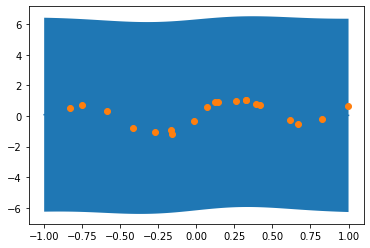

In [84]:
x_plot = x_pred[:, 0].numpy()
mean_plot = mean_pred.numpy()
std_plot  = tf.linalg.diag_part(cov_pred) ** 0.5

plt.plot(x_pred, mean_plot)
plt.fill_between(x_plot,
                 mean_plot - 2 * std_plot,
                 mean_plot + 2 * std_plot)
plt.scatter(x_train.numpy(), y_train.numpy())
plt.show()

In [85]:
print(vfe_gp.cov.scales, vfe_gp.noise)

tf.Tensor([0.36787944], shape=(1,), dtype=float64) tf.Tensor(3.029871886539901, shape=(), dtype=float64)
